# 2025-10-08 Low Rank

* Reflection on algorithm choices

* Low-rank structure

* Primer on interpolation

In [1]:
using LinearAlgebra
using Plots
using Polynomials
default(lw=4, ms=5, legendfontsize=12, xtickfontsize=12, ytickfontsize=12)
default(aspect_ratio=:equal)

# Here's our Vandermonde matrix again
function vander(x, k=nothing)
    if isnothing(k)
        k = length(x)
    end
    m = length(x)
    V = ones(m, k)
    for j in 2:k
        V[:, j] = V[:, j-1] .* x
    end
    V
end

# Our modifiend Gram Schmidt for QR
function gram_schmidt_modified(A)
    m, n = size(A)
    Q = copy(A)
    R = zeros(n, n)
    for j in 1:n
        # First we normalize our column
        R[j, j]  = norm(Q[:, j])
        Q[:, j] /= R[j, j]
        # Then we make all following columns orthogonal to the current
        R[j, j+1:end]  = Q[:, j]' * Q[:, j+1:end]
        Q[:, j+1:end] -= Q[:, j]  * R[j, j+1:end]'
    end
    Q, R
end

# Householder for QR
function qr_householder(A)
    m, n = size(A)
    R = copy(A)
    V = [] # list of reflectors
    for j in 1:n
        # Build v for the current column
        v = copy(R[j:end, j])
        v[1] += sign(v[1]) * norm(v) # Here's the fix!
        v = normalize(v)
        # Build and apply F
        R[j:end, j:end] -= 2 * v * (v' * R[j:end,j:end])
        # Keep track of the reflectors
        push!(V, v)
    end
    V, R
end

# Here's a function to apply the reflectors V to a vector x
function reflectors_mult(V, x)
    y = copy(x)
    for v in reverse(V)
        n = length(v) - 1
        # This is applying F as we did to form R
        y[end-n:end] -= 2 * v * (v' * y[end-n:end])
    end
    y
end

# Create a dense matrix Q from reflectors V
function reflectors_to_dense(V)
    m = length(V[1])
    Q = diagm(ones(m))
    # Apply the reflectors to the identity matrix to build Q
    for j in 1:m
        Q[:, j] = reflectors_mult(V, Q[:,j])
    end
    Q
end

# And Cholesky QR
function qr_chol(A)
    # First find R
    R = cholesky(A' * A).U
    Q = A / R # Triangular solves are easy
    Q, R
end

# Also Cholesky QR with actual orthogonality retained
function qr_chol2(A)
    # First one had loss of orthogonality
    R = cholesky(A' * A).U
    Q = A / R # Triangular solves are easy
    # So we Cholesky decompose twice
    R2 = cholesky(Q' * Q).U
    Q = Q / R2
    # Note, triangular * triangular = triangular
    R = R2 * R
    Q, R
end

# Finally our visualization aids
# Let's use the peanut blob again
function peanut()
    theta = LinRange(0, 2*pi, 50)
    r = 1 .+ .4*sin.(3*theta) + .6*sin.(2*theta)
    r' .* [cos.(theta) sin.(theta)]'
end

# and a perfect circle
function circle()
    theta = LinRange(0, 2*pi, 50)
    [cos.(theta) sin.(theta)]'
end

function Aplot(A)
    "Plot a transformation from X to Y"
    X = peanut()
    Y = A * X
    p = scatter(X[1,:], X[2,:], label="in")
    scatter!(p, Y[1,:], Y[2,:], label="out")
    X = circle()
    Y = A * X
    q = scatter(X[1,:], X[2,:], label="in")
    scatter!(q, Y[1,:], Y[2,:], label="out")
    plot(p, q, layout=2)
end

Aplot (generic function with 1 method)

## Condition number via SVD

Recall that we can compute the condition number of a matrix from its singular values.

$$ \begin{split} U \overbrace{\begin{bmatrix} \sigma_{\max} && \\ & \ddots & \\ && \sigma_{\min} \end{bmatrix}}^{\Sigma} V^T = A \end{split} $$

$$ \begin{align}
\lVert A \rVert &= \sigma_{\max} &
\kappa(A) &= \frac{\sigma_{\max}}{\sigma_{\min}} = \texttt{cond}(A)
\end{align} $$

In [2]:
# Let's make a random symmetric matrix
A = randn(2, 2)
A = A + A'

2×2 Matrix{Float64}:
 -0.603574   1.4332
  1.4332    -0.579078

svdvals(A) = [2.0245776363375425, 0.8419254291249848]
cond_A = maximum(S) / minimum(S) = 2.404699473730935
norm(U * U' - I) = 2.3551386880256624e-16
norm(V * V' - I) = 1.5700924586837752e-16


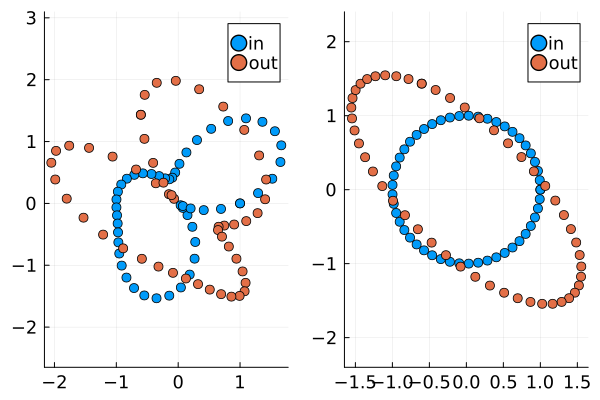

In [3]:
# The condition number is the ration of the largest and smallest singular value
@show svdvals(A)
U, S, V = svd(A)
@show cond_A = maximum(S) / minimum(S);

# U and V are in fact orthogonal
@show norm(U * U' - I)
@show norm(V * V' - I)

# Let's see what this matrix does to the peanut
Aplot(A)

## Least squares

Consider autonomous vehicles.

* Need to solve least squares problems in real time

* Weight/size/cost increase with computational needs

* What algorithm to choose?

* What precision to use?

### Factors

* How many objects to track?

* Speed (of robot and objects)

* Movement mode - aerial, wheeled, walking?

* Environment - fog, lighting, etc - longer memory needed?

* Tolerances (how accurate does the solution need to be?)

* Consequences of errors, and who is responsible?

In [4]:
# Let's look at the raw time to solve with our methods above
A = rand(5000, 500)
A_32 = Float32.(A)
@show cond(A)

println("\nHousholder, from Julia")
@time Q, R = qr(A); # Householder; backward stable
@show norm(Q * R - A)
@show norm(Q' * Q - I)

println("\nCholesky")
@time Q, R = qr_chol(A)   # Unstable
@show norm(Q * R - A)
@show norm(Q' * Q - I)

println("\nHousholder, single precision")
@time Q, R = qr(A_32);    # Lower precision
@show norm(Q * R - A)
@show norm(Q' * Q - I);

cond(A) = 56.41692986725042

Housholder, from Julia
  0.054616 seconds (16.12 k allocations: 22.086 MiB, 32.25% compilation time)
norm(Q * R - A) = 6.24924762487844e-13
norm(Q' * Q - I) = 3.437123182168262e-14

Cholesky
  0.095506 seconds (159.33 k allocations: 31.155 MiB, 6.33% gc time, 78.50% compilation time)
norm(Q * R - A) = 4.730759741134537e-14
norm(Q' * Q - I) = 1.0727471889927264e-12

Housholder, single precision
  0.153058 seconds (198.00 k allocations: 20.700 MiB, 86.54% compilation time)
norm(Q * R - A) = 0.0002844462779395801
norm(Q' * Q - I) = 1.7440289f-5


In [5]:
# And lets check with a particularly ill conditioned matrix
V = vander(LinRange(-1, 1, 22))
V_32 = Float32.(V)
@show cond(A)

println("\nHousholder, from Julia")
@time Q, R = qr(V); # Householder; backward stable
@show norm(Q * R - V)
@show norm(Q' * Q - I)

println("\nCholesky")
@time Q, R = qr_chol(V)   # Unstable
@show norm(Q * R - V)
@show norm(Q' * Q - I)

println("\nHousholder, single precision")
@time Q, R = qr(V_32);    # Lower precision
@show norm(Q * R - V)
@show norm(Q' * Q - I);

cond(A) = 56.41692986725042

Housholder, from Julia
  0.000077 seconds (16 allocations: 15.688 KiB)
norm(Q * R - V) = 3.5159362514746e-15
norm(Q' * Q - I) = 3.254229278676633e-15

Cholesky
  0.000037 seconds (16 allocations: 11.883 KiB)
norm(Q * R - V) = 3.0243458890798737e-16
norm(Q' * Q - I) = 1.0000208696450787

Housholder, single precision
  0.000060 seconds (12 allocations: 8.219 KiB)
norm(Q * R - V) = 1.8764177333132612e-6
norm(Q' * Q - I) = 1.8709579f-6


## Low rank approximation

The SVD can be truncated to yield the best rank-$k$ approximation of a matrix.

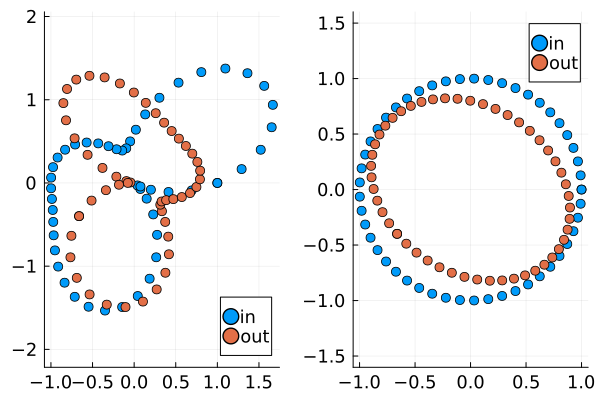

In [6]:
# Let's make a random rank 2 matrix
n, k = 2, 1

A = randn(n, n)
Aplot(A)

S[1:k + 1] = [0.960027152945952, 0.7466983390181022]
norm(Â) = 0.960027152945952


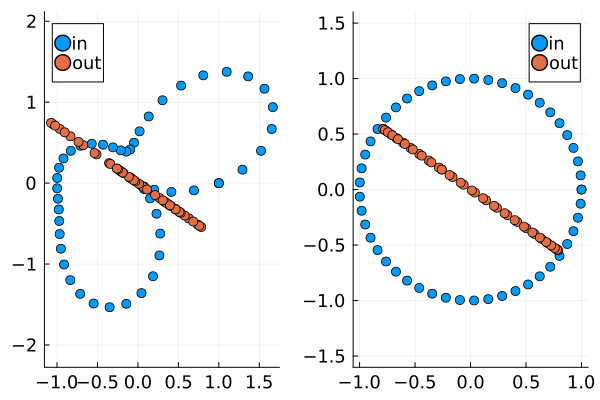

In [7]:
# Let's make the SVD
U, S, V = svd(A)

# Let's truncate out the last singular value
@show S[1:k+1]
Û = U[:, 1:k]
Ŝ = S[1:k]
Ṽ = V[:, 1:k]
Â = Û * diagm(Ŝ) * Ṽ'
@show norm(Â)
# Here's our reduced A
Aplot(Â)

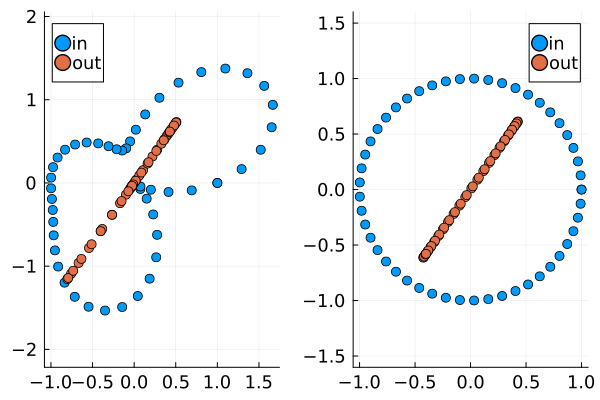

In [8]:
# And the part left out
Aplot(A - Â)

## Example: Galaxies

Suppose we have two galaxies of size $n_1 = 100$ and $n_2 = 200$, each randomly distributed around their respective centers.

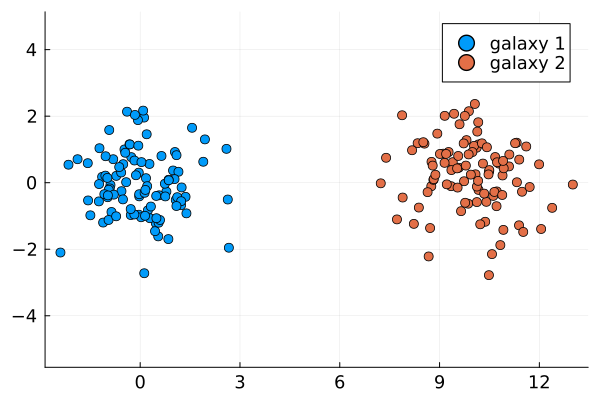

In [9]:
galaxy(center, sigma, n) = reshape(center, 1, 3) .+ sigma*randn(n, 3)
g1 = galaxy([0 0 0], 1, 100)
g2 = galaxy([10 0 0], 1, 100)

scatter(g1[:, 1], g1[:, 2], aspect_ratio=:equal, label="galaxy 1")
scatter!(g2[:, 1], g2[:, 2], label="galaxy 2")

### Force between stars

Consider the gravitational force from a star at position $x_2$ acting on a start at position $x_1$.

$$ F_{1, 2} = G \frac{m_1 m_2}{\left\lvert \left\lvert x_2 - x_1 \right\rvert \right\rvert^3} \left( x_2 - x_1 \right) $$

where $m_1$ and $m_2$ are the masses of each star, respectively.

In [10]:
# Let's make a matrix of all gravitational forces
function gravity(g1, g2)
    m = size(g1, 1)
    n = size(g2, 1)
    F = zeros(3*m, n)
    for i in 0:m-1
        for j in 1:n
            r = g2[j, :] - g1[1+i, :]
            F[1+3*i:3*(i+1), j] = r / norm(r)^3
        end
    end
    F
end

gravity(g1, g2)

300×100 Matrix{Float64}:
  0.0112667     0.0101826     0.00903903   …   0.00703791    0.00942865
  0.00203545    0.00149536   -0.00018392       0.00123964    0.00172431
 -0.00282527   -0.00141143   -0.00104142      -0.000169608  -0.00128638
  0.0122063     0.0102837     0.00838692       0.00694382    0.00970797
 -0.000191784  -0.000333167  -0.00153181       0.000187078   7.82843e-5
 -0.00072695    0.000350617   0.000369862  …   0.000811836   0.000302622
  0.0212322     0.0165159     0.0121879        0.010089      0.0155475
 -0.0021043    -0.0018445    -0.00358215      -0.000223007  -0.000885582
  6.40837e-5    0.0019341     0.00148588       0.00203266    0.0017143
  0.00913933    0.00795759    0.00698091       0.0055671     0.00747452
  0.0010269     0.000701899  -0.000374983  …   0.000685448   0.000904006
 -0.000642963   0.000104849   0.000163943      0.000506882   8.31783e-5
  0.0129363     0.0113339     0.010316         0.00744174    0.0103632
  ⋮                                    

### Spectrum (Singular values)

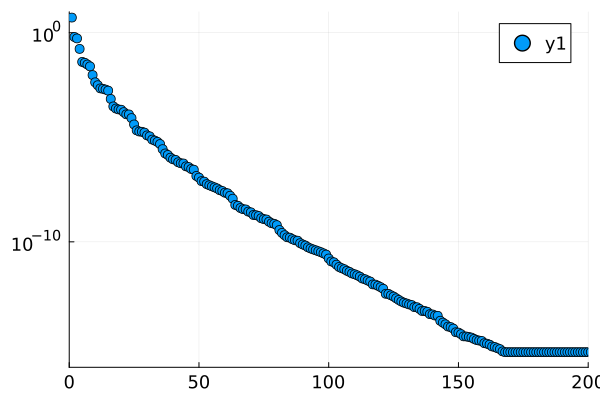

In [11]:
# A new pair of galaxies
g1 = galaxy([0 0 0], 1, 500)
g2 = galaxy([10 0 0], 1, 500)
F = gravity(g1, g2)

# Let's plot the singular values
U, S, V = svd(F)
default(aspect_ratio=:auto)
scatter(S, yscale=:log10, ylims=(1e-16, 1e1), xlims=(0, 200))

In [12]:
# Let's make a minimal model
k = 10
Û = U[:, 1:k]
Ŝ = S[1:k]
Ṽ = V[:, 1:k]
F́ = Û * diagm(Ŝ) * Ṽ'

# And how good does it do?
@show norm(F - F́)

norm(F - F́) = 0.005090573699251146


0.005090573699251146

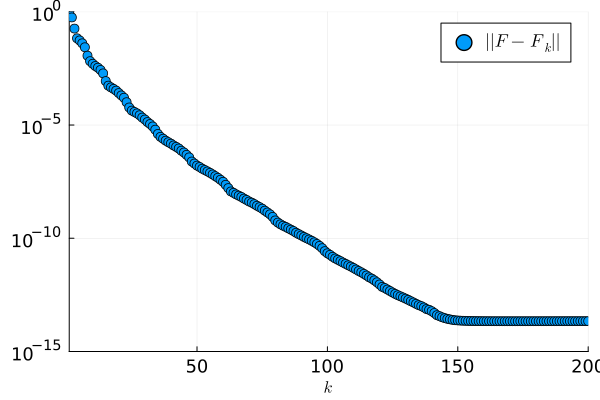

In [13]:
# Let's make a minimal model
n = 200
norm_err = zeros(n)
for k in 1:n
    Û = U[:, 1:k]
    Ŝ = S[1:k]
    Ṽ = V[:, 1:k]
    F́ = Û * diagm(Ŝ) * Ṽ'
    norm_err[k] = norm(F -  F́)
end

scatter(norm_err, yscale=:log10, ylims=(1e-15, 1e0), xlims=(1, n), label="\$\\vert \\vert F - F_k \\vert \\vert\$", xlabel="\$k\$")

## What is interpolation?

Given data $\left( x_i, y_i \right)$, find a (smooth?) function $f \left( x \right)$ such that $f \left( x_i \right) = y_i$.

### Data in

* Direct field observations/measurements of physical or social system

* Numerically processed observations, perhaps by applying physical principles

* Output from an expensive "exact" numerical computation

* Output from an approximate numerical computation

### Function out

* Polynomials

* Piecewise polynomials (includes nearest-neighbor)

* Powers and exponentials

* Trigonometric functions (sine and cosine)

* Neural networks

Interpolation fits the data **exactly**!

## Polynomial interpolation

We've seen how we can fit a polynomial using Vandermonde matrices, with one column per basis function and one row per observation.

$$ \underbrace{\Bigg[ 1 \Bigg| x \Bigg| x^2 \Bigg| x^3 \Bigg]}_{A \in \mathbb R^{m\times n}} \Bigg[ \mathbf p \Bigg] = \Bigg[ \mathbf y \Bigg] $$

It's possible to find a unique polynomial **$p$** when which of the following are true?

1) $m \leq n$

2) $m = n$

3) $m \geq n$

### Polynomial interpolation with Vandermonde

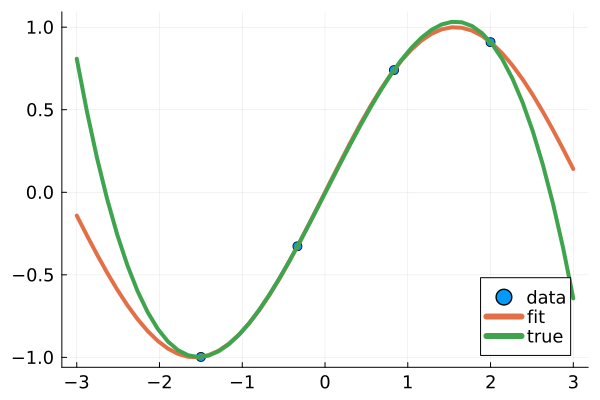

In [14]:
# Let's build some data
x = LinRange(-1.5, 2, 4)
y = sin.(x)

# And find coefficients so that A p = y
A = vander(x)
p = A \ y

# How well did we match?
scatter(x, y, label="data")
s = LinRange(-3, 3, 50)
plot!(s, [sin.(s) vander(s, length(p)) * p], label=["fit" "true"])

Recall that Vandermonde matrices can be ill-conditioned.

In [15]:
for i in 1:5
    A = vander(LinRange(-1, 1, 10 * i))
    println("k = $i, cond(A) = $(cond(A))")
end

k = 1, cond(A) = 4626.449923375609
k = 2, cond(A) = 2.7224082423906505e8
k = 3, cond(A) = 1.8388423738279527e13
k = 4, cond(A) = 9.028174036334257e17
k = 5, cond(A) = 5.645434903563094e18


Is this due to the points $x$?

Or is this because of the basis functions $\lbrace 1, x, x^2, x^3, \dots \rbrace$?

Or something else?